In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')

In [14]:
import math

def entropy( x, b ):
    s = 0
    for p in x:
        if p > 0:
            s += -p*math.log(p,b)
        # end
    # end
    return s
# end

def visualize_regions(model, MAX, nGrid):
    a1 = np.linspace(-MAX, MAX, nGrid)
    a2 = np.linspace(-MAX, MAX, nGrid)

    A1, A2 = np.meshgrid(a1, a2)
    A1 = A1.flatten()
    A2 = A2.flatten()
    A = np.vstack((A1, A2)).T

    # Predict B
    B = model.predict(A)
    B = B.reshape(nGrid, nGrid)
    B = np.flipud(B)

    # Compute entropy for S
    prob_2D = model.predict_proba(A)
    S = np.array([entropy(p, 2) for p in prob_2D])
    S = S.reshape(nGrid, nGrid)
    S = np.flipud(S)

    return B, S
# end
    
def GenerateData(n_pts1,n_pts2,center_sep,std):
    
    cov = std**2*np.eye(2)
    
    x1 = np.random.multivariate_normal(mean=[-center_sep/2,0],
                                       cov=cov,
                                       size=n_pts1)
    y1 = np.zeros(n_pts1)
    
    x2 = np.random.multivariate_normal(mean=[center_sep/2,0],
                                       cov=cov,
                                       size=n_pts2)
    y2 = np.ones(n_pts2)
    
    X = np.concatenate((x1,x2),axis=0)
    y = np.concatenate((y1,y2),axis=0).astype(int)
    
    return X, y
# end

# Create data

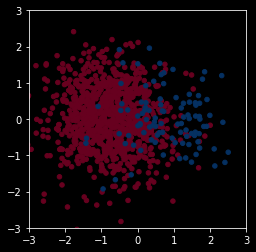

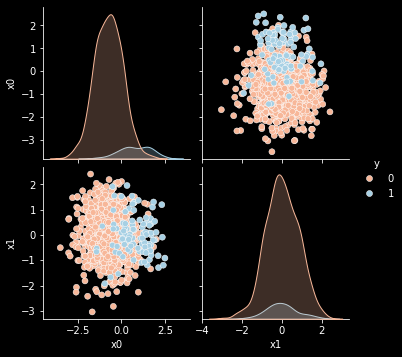

In [15]:
#np.random.seed(0)

n_pts0     = 1000
n_pts1     = 100
std        = 0.8
center_sep = 1.5

# generate data
X, y = GenerateData(
    n_pts0,
    n_pts1,
    center_sep,
    std
)

MAX = np.max(np.abs(X))

cmap = 'RdBu'

plt_scale = 3
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap=cmap)
plt.xlim(-plt_scale,plt_scale)
plt.ylim(-plt_scale,plt_scale)
plt.gca().set_aspect('equal')
plt.show()

df = pd.DataFrame( {"x0":X[:,0], "x1":X[:,1], "y":y} )
sns.pairplot(df, hue='y', palette='RdBu')
plt.show()

# Modeling w/o balancing

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
)

print("Original data:")
print(pd.Series(y).value_counts())
print()
print("Training data:")
print(pd.Series(y_train).value_counts())
print()
print("Testing data:")
print(pd.Series(y_test).value_counts())

Original data:
0    1000
1     100
Name: count, dtype: int64

Training data:
0    800
1     80
Name: count, dtype: int64

Testing data:
0    200
1     20
Name: count, dtype: int64


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=1,   weights='uniform'),
    KNeighborsClassifier(n_neighbors=5,   weights='uniform'),
    KNeighborsClassifier(n_neighbors=10,  weights='uniform'),
    KNeighborsClassifier(n_neighbors=50,  weights='uniform'),
    RandomForestClassifier(n_estimators=10,  max_leaf_nodes=3),
    RandomForestClassifier(n_estimators=10,  max_leaf_nodes=10),
    RandomForestClassifier(n_estimators=100, max_leaf_nodes=3),
    RandomForestClassifier(n_estimators=100, max_leaf_nodes=10),
    RandomForestClassifier(n_estimators=100, max_leaf_nodes=30),
    GradientBoostingClassifier(n_estimators=10,  learning_rate=0.1, max_leaf_nodes=3),
    GradientBoostingClassifier(n_estimators=10,  learning_rate=0.1, max_leaf_nodes=10),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_leaf_nodes=3),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_leaf_nodes=10),
]

LogisticRegression()
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       200
           1       0.67      0.40      0.50        20

    accuracy                           0.93       220
   macro avg       0.80      0.69      0.73       220
weighted avg       0.92      0.93      0.92       220



ValueError: Unknown format code 'd' for object of type 'float'

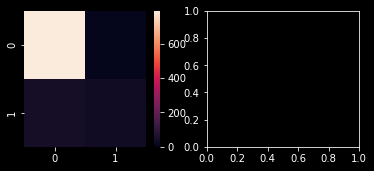

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

for m in models:
    m.fit(X_train, y_train)
    y_train_pred = m.predict(X_train).astype(int)
    y_test_pred = m.predict(X_test).astype(int)
    
    print(m)
    print(classification_report(y_test, y_test_pred))
    
    conf_matrix_train = confusion_matrix(y_train, y_train_pred).astype(float)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred).astype(float)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5))
    
    sns.heatmap(conf_matrix_train, annot=True, vmin=0, fmt='d', ax=axes[0])
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    axes[0].set_title("Training Data")
    
    sns.heatmap(conf_matrix_test, annot=True, vmin=0, fmt='d', ax=axes[1])
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    axes[1].set_title("Testing Data")
    
    plt.tight_layout()
    plt.show()

    B, S = visualize_regions(m, MAX, 200)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    extent = [-MAX,MAX,-MAX,MAX]
    
    cmap = "RdBu"
    axes[0].imshow(B, interpolation='none', extent=extent,cmap=cmap, alpha=0.4)
    axes[0].scatter(X_train[:,0], X_train[:,1], c=y_train, s=10, cmap=cmap);
    axes[0].set_aspect('equal')
    axes[0].set_title('Training data');
    
    axes[1].imshow(B, interpolation='none', extent=extent,cmap=cmap, alpha=0.4)
    axes[1].scatter(X_test[:,0], X_test[:,1], c=y_test, s=10, cmap=cmap);
    axes[1].set_aspect('equal')
    axes[1].set_title('Testing data');
    
    im = axes[2].imshow(S, interpolation='none', extent=extent,cmap='gray')
    axes[2].scatter(X_test[:,0], X_test[:,1], c=y_test, s=20, cmap=cmap);
    axes[2].set_aspect('equal')
    axes[2].set_title('Entropy')
    cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_ticks(np.linspace(0, math.log(y.max()+1,2), 10))

    plt.tight_layout()
    plt.show()
# end

# Modeling w/ manual balancing via resampling

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
)

In [ ]:
n_resamp = 1000

idx_train_0 = np.where(y_train==0)[0]
idx_train_1 = np.where(y_train==1)[0]

idx_train_0 = np.random.choice(idx_train_0, n_resamp)
idx_train_1 = np.random.choice(idx_train_1, n_resamp)

X_train_bal = np.concatenate(
    ( X_train[idx_train_0,:], X_train[idx_train_1,:] ),
    axis=0
)

y_train_bal = np.concatenate(
    ( y_train[idx_train_0], y_train[idx_train_1] ),
    axis=0
)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

for m in models:
    m.fit(X_train_bal, y_train_bal)
    y_train_bal_pred = m.predict(X_train_bal).astype(int)
    y_test_bal_pred = m.predict(X_test).astype(int)
    
    print(m)
    print(classification_report(y_test, y_test_bal_pred))
    
    conf_matrix_train = confusion_matrix(y_train_bal, y_train_bal_pred).astype(float)
    conf_matrix_test = confusion_matrix(y_test, y_test_bal_pred).astype(float)
    #for i in range(conf_matrix_train.shape[0]):
        #conf_matrix_train[i,:] = conf_matrix_train[i,:] / conf_matrix_train[i,:].sum()
        #conf_matrix_test[i,:]  = conf_matrix_test[i,:] / conf_matrix_test[i,:].sum()
    # end
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5))
    
    sns.heatmap(conf_matrix_train, annot=True, vmin=0, fmt='.3f', ax=axes[0])
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    axes[0].set_title("Training Data")
    
    sns.heatmap(conf_matrix_test, annot=True, vmin=0, fmt='.3f', ax=axes[1])
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    axes[1].set_title("Testing Data")
    
    plt.tight_layout()
    plt.show()

    B, S = visualize_regions(m, MAX, 200)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    extent = [-MAX,MAX,-MAX,MAX]
    
    cmap = "RdBu"
    axes[0].imshow(B, interpolation='none', extent=extent,cmap=cmap, alpha=0.4)
    axes[0].scatter(X_train[:,0], X_train[:,1], c=y_train, s=10, cmap=cmap);
    axes[0].set_aspect('equal')
    axes[0].set_title('Training data');
    
    axes[1].imshow(B, interpolation='none', extent=extent,cmap=cmap, alpha=0.4)
    axes[1].scatter(X_test[:,0], X_test[:,1], c=y_test, s=10, cmap=cmap);
    axes[1].set_aspect('equal')
    axes[1].set_title('Testing data');
    
    im = axes[2].imshow(S, interpolation='none', extent=extent,cmap='gray')
    axes[2].scatter(X_test[:,0], X_test[:,1], c=y_test, s=20, cmap=cmap);
    axes[2].set_aspect('equal')
    axes[2].set_title('Entropy')
    cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_ticks(np.linspace(0, math.log(y.max()+1,2), 10))

    plt.tight_layout()
    plt.show()
# end